In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [3]:
import tensorflow as tf 
import os

2024-06-15 20:25:36.346969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 20:25:36.347104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 20:25:36.469693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def load_image(image_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

def load_dataset(directory, target_size=(256, 256)):
    high_light_dir = os.path.join(directory, 'high')
    low_light_dir = os.path.join(directory, 'low')
    
    high_light_images = [os.path.join(high_light_dir, img) for img in os.listdir(high_light_dir)]
    low_light_images = [os.path.join(low_light_dir, img) for img in os.listdir(low_light_dir)]
    
    high_light_dataset = tf.data.Dataset.from_tensor_slices(high_light_images)
    low_light_dataset = tf.data.Dataset.from_tensor_slices(low_light_images)
    
    high_light_dataset = high_light_dataset.map(lambda x: load_image(x, target_size))
    low_light_dataset = low_light_dataset.map(lambda x: load_image(x, target_size))
    
    return high_light_dataset, low_light_dataset

In [6]:
train_dir = '/kaggle/input/lol-dataset/lol_dataset/our485'
val_dir = '/kaggle/input/lol-dataset/lol_dataset/eval15'

train_high_light_dataset, train_low_light_dataset = load_dataset(train_dir)
val_high_light_dataset, val_low_light_dataset = load_dataset(val_dir)

# Combine high and low light datasets
train_dataset = tf.data.Dataset.zip((train_low_light_dataset, train_high_light_dataset))
val_dataset = tf.data.Dataset.zip((val_low_light_dataset, val_high_light_dataset))

# Optional: Shuffle and batch the datasets
batch_size = 4

train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [7]:
print(len(train_dataset))
print(len(val_dataset))

122
4


In [67]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Input, BatchNormalization,Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

"""vgg = VGG19(include_top=False, input_shape=input_shape)
    for layer in vgg.layers:
        layer.trainable = False
    
    # Extract layers for the downsampling part of the generator
    x = vgg(inputs)
    """
    

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Input, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Input, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model

def build_simple_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    # Downsample
    d1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)  # 64x64x64
    d1 = LeakyReLU(alpha=0.2)(d1)
    
    d2 = Conv2D(128, kernel_size=4, strides=2, padding='same')(d1)  # 32x32x128
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)
    
    d3 = Conv2D(256, kernel_size=4, strides=2, padding='same')(d2)  # 16x16x256
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)
    
    d4 = Conv2D(512, kernel_size=4, strides=2, padding='same')(d3)  # 8x8x512
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)
    
    d5 = Conv2D(512, kernel_size=4, strides=2, padding='same')(d4)  # 4x4x512
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU(alpha=0.2)(d5)
    
    
    # Bottleneck
    bottleneck = Conv2D(512, kernel_size=4, strides=1, padding='same')(d5)  # 4x4x512
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = LeakyReLU(alpha=0.2)(bottleneck)
    
    # Upsample
    u0 = Conv2DTranspose(512, kernel_size=4, strides=1, padding='same')(bottleneck)  # 4x4x512
    u0 = BatchNormalization()(u0)
    u0 = Activation('relu')(u0)
    u0 = Concatenate()([u0, d5])
    
    u1 = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(u0)  # 8x8x512
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Concatenate()([u1, d4])
    
    u2 = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(u1)  # 16x16x512
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Concatenate()([u2, d3])
    
    u3 = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(u2)  # 32x32x256
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Concatenate()([u3, d2])
    
    u4 = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(u3)  # 64x64x128
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Concatenate()([u4, d1])
    
    u5 = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(u4)  # 128x128x64
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)

    # Output layer
    outputs = Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh')(u5)  # 128x128x3
    
    return Model(inputs, outputs)

G = build_simple_generator()
G.summary()

F = build_simple_generator()

""""""

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 128, 128,  │      3,136 │ input_layer_20[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_90      │ (None, 128, 128,  │          0 │ conv2d_94[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 64, 64,    │    131,200 │ leaky_re_lu_90[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_91      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 32, 32,    │    524,544 │ leaky_re_lu_91[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_92      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 16, 16,    │  2,097,664 │ leaky_re_lu_92[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_93      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_93[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_94      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 8, 8, 512) │  4,194,816 │ leaky_re_lu_94[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_99[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 36,265,795 (138.34 MB)

 Trainable params: 36,257,987 (138.31 MB)

 Non-trainable params: 7,808 (30.50 KB)

''

In [ ]:
from keras.utils import plot_model
plot_model(G,show_shapes = True, show_layer_names = True, to_file='Generator_Model.png')

In [68]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.activations import sigmoid

def build_simple_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    
    outputs = Dense(1,activation='sigmoid')(x)
    
    
    return Model(inputs, outputs)

# Example usage
D_X = build_simple_discriminator()
D_X.summary()

D_Y = build_simple_discriminator()


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_102 (LeakyReLU)     │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_103 (LeakyReLU)     │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_104 (LeakyReLU)     │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 16, 16, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_105 (LeakyReLU)     │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,887,617 (11.02 MB)

 Trainable params: 2,887,617 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.utils import plot_model
plot_model(D_Y,show_shapes = True, show_layer_names = True, to_file='Discriminator_Model(D_Y).png')

In [57]:
"""import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix"""

'import tensorflow_datasets as tfds\nfrom tensorflow_examples.models.pix2pix import pix2pix'

In [58]:
"""OUTPUT_CHANNELS = 3

G= pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
F = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

D_X = pix2pix.discriminator(norm_type='instancenorm', target=False)
D_Y = pix2pix.discriminator(norm_type='instancenorm', target=False)"""

"OUTPUT_CHANNELS = 3\n\nG= pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')\nF = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')\n\nD_X = pix2pix.discriminator(norm_type='instancenorm', target=False)\nD_Y = pix2pix.discriminator(norm_type='instancenorm', target=False)"

In [71]:
from tensorflow.keras.optimizers import Adam

# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity):
    return lambda_identity * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

In [72]:
# Optimizers
generator_g_optimizer = Adam(2e-4)
generator_f_optimizer = Adam(2e-4)
discriminator_x_optimizer = Adam(2e-3)
discriminator_y_optimizer = Adam(2e-3)

In [73]:
# Training step function
gen_g_losses=[]
gen_f_losses=[]
disc_x_losses=[]
disc_y_losses=[]

@tf.function
def train_step(real_x, real_y, G, F, D_X, D_Y, lambda_cycle, lambda_identity):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X to Y
        fake_y = G(real_x, training=True)
        # Generator F translates Y to X
        fake_x = F(real_y, training=True)

        # Cycle consistency
        cycled_x = F(fake_y, training=True)
        cycled_y = G(fake_x, training=True)

        # Identity mapping
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator output
        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        # Calculate the losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        cycle_loss_g = cycle_consistency_loss(real_x, cycled_x, lambda_cycle)
        cycle_loss_f = cycle_consistency_loss(real_y, cycled_y, lambda_cycle)

        identity_loss_g = identity_loss(real_y, same_y, lambda_identity)
        identity_loss_f = identity_loss(real_x, same_x, lambda_identity)

        total_gen_g_loss = gen_g_loss + cycle_loss_g + identity_loss_g
        total_gen_f_loss = gen_f_loss + cycle_loss_f + identity_loss_f

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients
    gradients_of_generator_g = tape.gradient(total_gen_g_loss, G.trainable_variables)
    gradients_of_generator_f = tape.gradient(total_gen_f_loss, F.trainable_variables)

    gradients_of_discriminator_x = tape.gradient(disc_x_loss, D_X.trainable_variables)
    gradients_of_discriminator_y = tape.gradient(disc_y_loss, D_Y.trainable_variables)

    # Apply the gradients to the optimizers
    generator_g_optimizer.apply_gradients(zip(gradients_of_generator_g, G.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(gradients_of_generator_f, F.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(gradients_of_discriminator_x, D_X.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(gradients_of_discriminator_y, D_Y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [74]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [75]:
val_high_images=list(val_high_light_dataset.as_numpy_iterator())
val_low_images=list(val_low_light_dataset.as_numpy_iterator())

example_real_x=val_low_images[0]
example_real_y=val_high_images[0]

In [76]:
def denormalize_image(image):
    """Convert an image from [-1, 1] to [0, 1] for visualization."""
    return (image + 1.0) / 2.0

def plot_generated_images(generator,input_image,title):
    generated_image=generator(tf.expand_dims(input_image,0),training=False)[0]
    
    input_image=denormalize_image(input_image)
    generated_image=denormalize_image(generated_image)
    
    plt.imshow(np.hstack([input_image,generated_image]))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [77]:
def loss_plot(gen_g_losses,gen_f_losses,disc_x_losses,disc_y_losses,epoch):
    plt.figure(figsize=(10,5))
    plt.plot(gen_g_losses,label='Generator G Loss')
    plt.plot(gen_f_losses,label='Generator F Loss')
    plt.plot(disc_x_losses,label='Discriminator X Loss')
    plt.plot(disc_y_losses,label='Discriminator Y Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.grid(True)
    
    plt.show()

Epoch 100/100
Generator G Loss: 25645.94921875, Generator F Loss: 30.77134895324707
Discriminator X Loss: 26.485126495361328, Discriminator Y Loss: 0.0


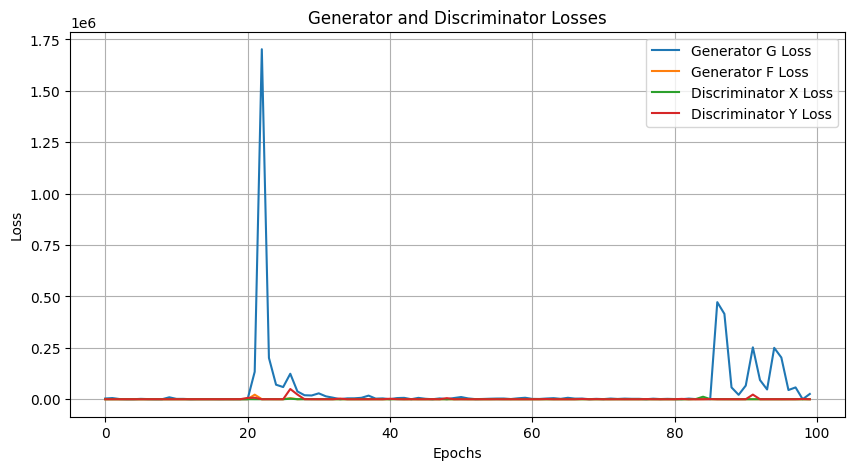

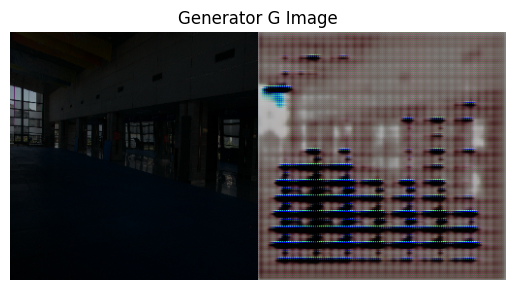

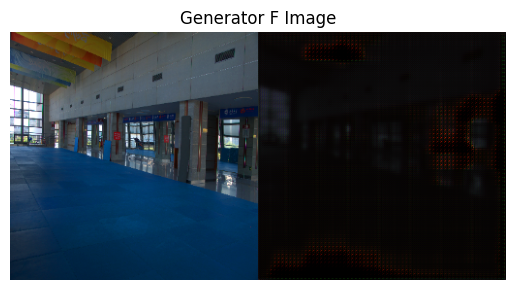

In [78]:
epochs = 100
lambda_cycle = 10.0
lambda_identity = 0.5


for epoch in range(epochs):
    clear_output(wait=True)
    
    for real_x, real_y in train_dataset:
        total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(real_x, real_y, G, F, D_X, D_Y, lambda_cycle=10.0, lambda_identity=0.5)
    
    gen_g_losses.append(total_gen_g_loss.numpy())
    gen_f_losses.append(total_gen_f_loss.numpy())
    disc_x_losses.append(disc_x_loss.numpy())
    disc_y_losses.append(disc_y_loss.numpy())
    
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Generator G Loss: {total_gen_g_loss}, Generator F Loss: {total_gen_f_loss}')
    print(f'Discriminator X Loss: {disc_x_loss}, Discriminator Y Loss: {disc_y_loss}')
    
    loss_plot(gen_g_losses,gen_f_losses,disc_x_losses,disc_y_losses,epoch)
    
    plot_generated_images(G,example_real_x,'Generator G Image')
    plot_generated_images(F,example_real_y,'Generator F Image')

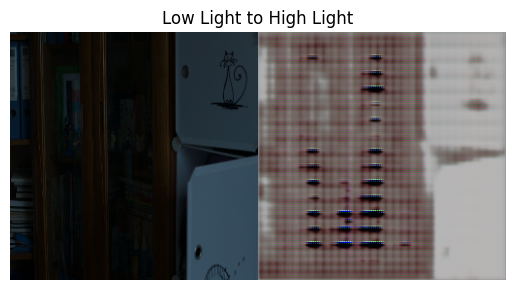

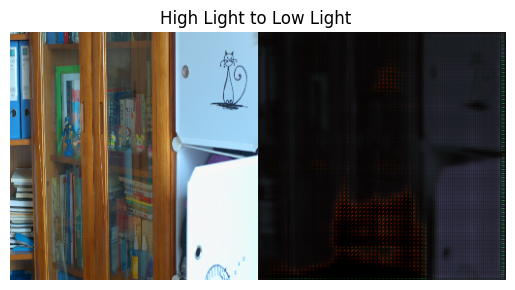

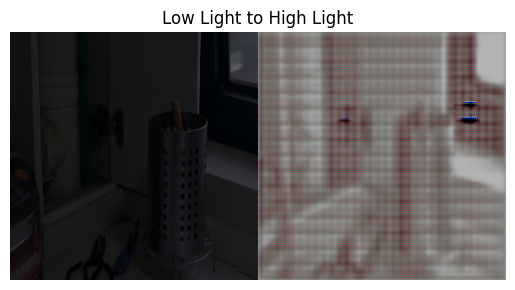

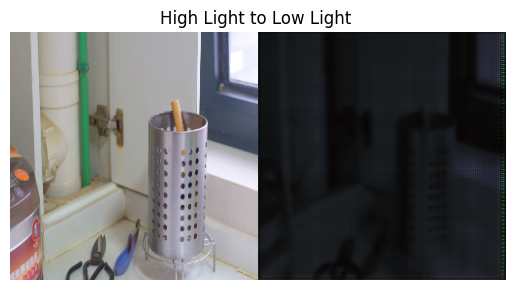

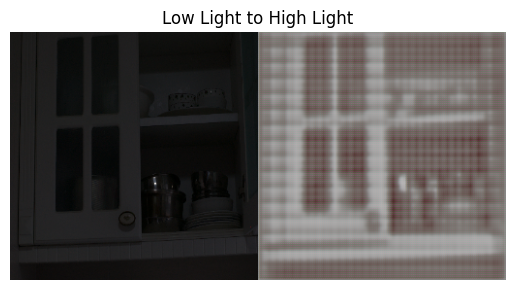

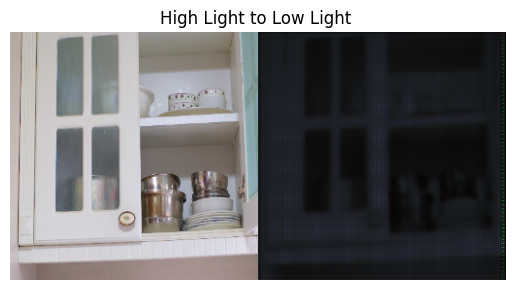

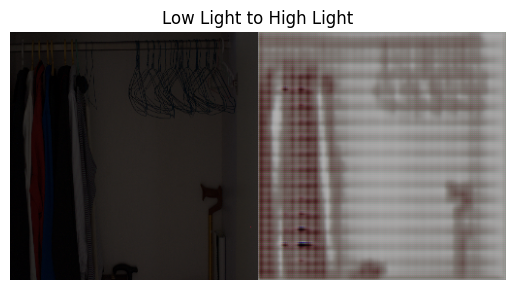

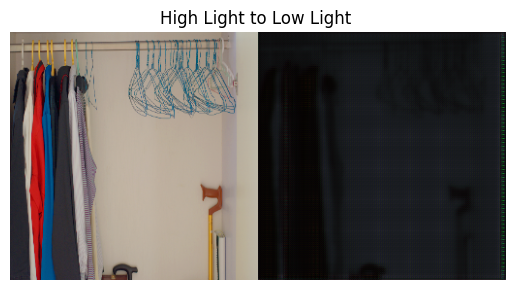

In [79]:
from random import randint
for i in range(0,4):
    
    l=randint(0,14)
    
    example_real_x=val_low_images[l]
    example_real_y=val_high_images[l]

    plot_generated_images(G,example_real_x,'Low Light to High Light')
    plot_generated_images(F,example_real_y,'High Light to Low Light ')

In [ ]:
# Assuming generator and discriminator are your model instances

# Save weights
F.save_weights('generator_weights.h5')
D_Y.save_weights('discriminator_weights.h5')
